11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:780: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch   1/600 – G_loss 0.6311  D_loss 1.3646
Epoch   2/600 – G_loss 0.6060  D_loss 1.3387
Epoch   3/600 – G_loss 0.5843  D_loss 1.3340
Epoch   4/600 – G_loss 0.5826  D_loss 1.3273
Epoch   5/600 – G_loss 0.5792  D_loss 1.3387
Epoch   6/600 – G_loss 0.5733  D_loss 1.3622
Epoch   7/600 – G_loss 0.5844  D_loss 1.3648
Epoch   8/600 – G_loss 0.6038  D_loss 1.3592
Epoch   9/600 – G_loss 0.6224  D_loss 1.3631
Epoch  10/600 – G_loss 0.6394  D_loss 1.3742
Epoch  11/600 – G_loss 0.6548  D_loss 1.3843
Epoch  12/600 – G_loss 0.6747  D_loss 1.3846
Epoch  13/600 – G_loss 0.7003  D_loss 1.3729
Epoch  14/600 – G_loss 0.7193  D_loss 1.3655
Epoch  15/600 – G_loss 0.7283  D_loss 1.3667
Epoch  16/600 – G_loss 0.7289  D_loss 1.3732
Epoch  17/600 – G_loss 0.7258  D_loss 1.3801
Epoch  18/600 – G_loss 0.7265  D_loss 1.3805
Epoch  19/600 – G_loss 0.7307  D_loss 1.3745
Epoch  20/600 – G_loss 0.7380  D_loss 1.3662
Epoch  21/600 – G_loss 0.7424  D_loss 1.3617
Epoch  22/600 – G_loss 0.7462  D_loss 1.3626
Epoch  23/

Epoch 600/600 – G_loss 0.8647  D_loss 1.3244
Generator saved to dcgan_generator.h5
Images written to gen_samples_dcgan/


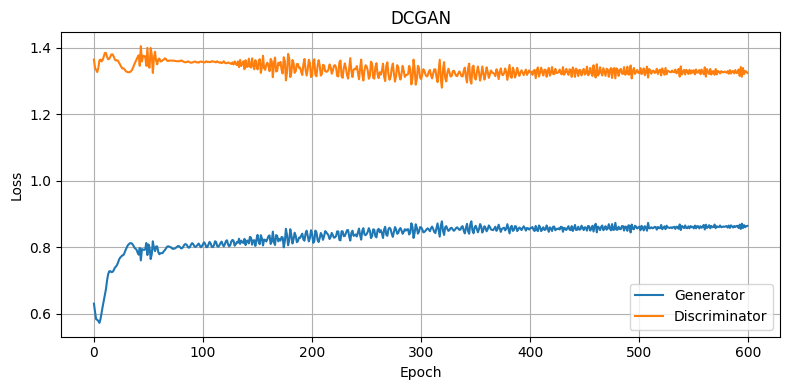

In [1]:
import tensorflow as tf
from tensorflow.keras.mixed_precision import set_global_policy
from tensorflow.keras import layers
import matplotlib.pyplot as plt, numpy as np, imageio, pathlib, os

# Mixed Precision
tf.config.optimizer.set_jit(True)           # XLA
set_global_policy("mixed_float16")          # FP16 where safe

# Optional: make TF log less chatty
tf.get_logger().setLevel("ERROR")

# Data
(train_images, _), _ = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(-1, 28, 28, 1).astype("float32")
train_images = (train_images - 127.5) / 127.5        # [-1, 1]

BUFFER_SIZE = 60_000
BATCH_SIZE  = 4096  # big batch
train_ds = (tf.data.Dataset.from_tensor_slices(train_images)
            .cache()                                  # stays in RAM
            .shuffle(BUFFER_SIZE)
            .batch(BATCH_SIZE, drop_remainder=True)   # constant size
            .prefetch(tf.data.AUTOTUNE))

# 2. Model
LATENT_DIM = 100

def make_generator():
    return tf.keras.Sequential([
        layers.Input(shape=(1, 1, LATENT_DIM)),
        layers.Conv2DTranspose(192, 7, strides=1, padding="valid"),  # 256→192
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(128, 4, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(64, 4, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(1, 3, strides=1, padding="same",
                               activation="tanh", dtype="float32"),  # final FP32
    ], name="dcgan_generator")

def make_discriminator():
    return tf.keras.Sequential([
        layers.Input(shape=(28, 28, 1)),
        layers.Conv2D(64, 4, strides=2, padding="same"),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Conv2D(128, 4, strides=2, padding="same"),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Conv2D(1, 7, strides=1, padding="valid", dtype="float32"),  # logits in FP32
        layers.Activation("sigmoid", dtype="float32"),
    ], name="dcgan_discriminator")

generator     = make_generator()
discriminator = make_discriminator()

# 3. Loss & Optims
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def gen_loss(fake_out):
    return bce(tf.ones_like(fake_out), fake_out)

def disc_loss(real_out, fake_out):
    real_labels = tf.ones_like(real_out) * 0.9
    fake_labels = tf.zeros_like(fake_out)
    return bce(real_labels, real_out) + bce(fake_labels, fake_out)

g_opt = tf.keras.optimizers.Adam(2.5e-5, 0.5)  # keep master weights in FP32
d_opt = tf.keras.optimizers.Adam(2.5e-5, 0.5)

# 4. Train Step
@tf.function(jit_compile=True)           # extra hint for XLA
def train_step(real_imgs):
    noise = tf.random.normal([BATCH_SIZE, 1, 1, LATENT_DIM])

    with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
        fake_imgs = generator(noise, training=True)
        real_out  = discriminator(real_imgs, training=True)
        fake_out  = discriminator(fake_imgs, training=True)

        g_loss = gen_loss(fake_out)
        d_loss = disc_loss(real_out, fake_out)

    g_grads = g_tape.gradient(g_loss, generator.trainable_variables)
    d_grads = d_tape.gradient(d_loss, discriminator.trainable_variables)
    g_opt.apply_gradients(zip(g_grads, generator.trainable_variables))
    d_opt.apply_gradients(zip(d_grads, discriminator.trainable_variables))
    return g_loss, d_loss

# 5. Helper ‑ Images
def save_grid(images, path, cols=5):
    imgs = (images + 1) / 2.0
    rows = (len(imgs) + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(cols*2, rows*2))
    axes = axes.flatten()
    for i, img in enumerate(imgs):
        axes[i].imshow(img[:, :, 0], cmap="gray")
        axes[i].axis("off")
    for ax in axes[len(imgs):]:
        ax.axis("off")
    plt.tight_layout()
    plt.savefig(path, dpi=150)
    plt.close()

def generate_and_save(generator, num_samples=25, out_dir="gen_samples_dcgan"):
    pathlib.Path(out_dir).mkdir(exist_ok=True)
    noise = tf.random.normal([num_samples, 1, 1, LATENT_DIM])
    gen   = generator(noise, training=False)
    gen   = (gen + 1) / 2.0

    for i, img in enumerate(gen):
        img_u8 = tf.image.convert_image_dtype(img, tf.uint8)
        imageio.imwrite(f"{out_dir}/digit_{i:04d}.png", img_u8.numpy().squeeze())

    save_grid(gen.numpy(), f"{out_dir}/grid.png")

# 6. Training Loop
EPOCHS = 600
g_losses, d_losses = [], []

for epoch in range(EPOCHS):
    g_tot = d_tot = batches = 0
    for batch in train_ds:
        g_loss, d_loss = train_step(batch)
        g_tot += g_loss
        d_tot += d_loss
        batches += 1

    g_losses.append(g_tot / batches)
    d_losses.append(d_tot / batches)
    print(f"Epoch {epoch+1:3d}/{EPOCHS} – "
          f"G_loss {g_losses[-1]:6.4f}  D_loss {d_losses[-1]:6.4f}")

# 7. Post‑Training
generator.save("dcgan_generator.h5")
print("Generator saved to dcgan_generator.h5")

generate_and_save(generator, num_samples=25)
print("Images written to gen_samples_dcgan/")

# Loss curves (quick sanity)
plt.figure(figsize=(8,4))
plt.plot(g_losses, label="Generator")
plt.plot(d_losses, label="Discriminator")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.title("DCGAN")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()


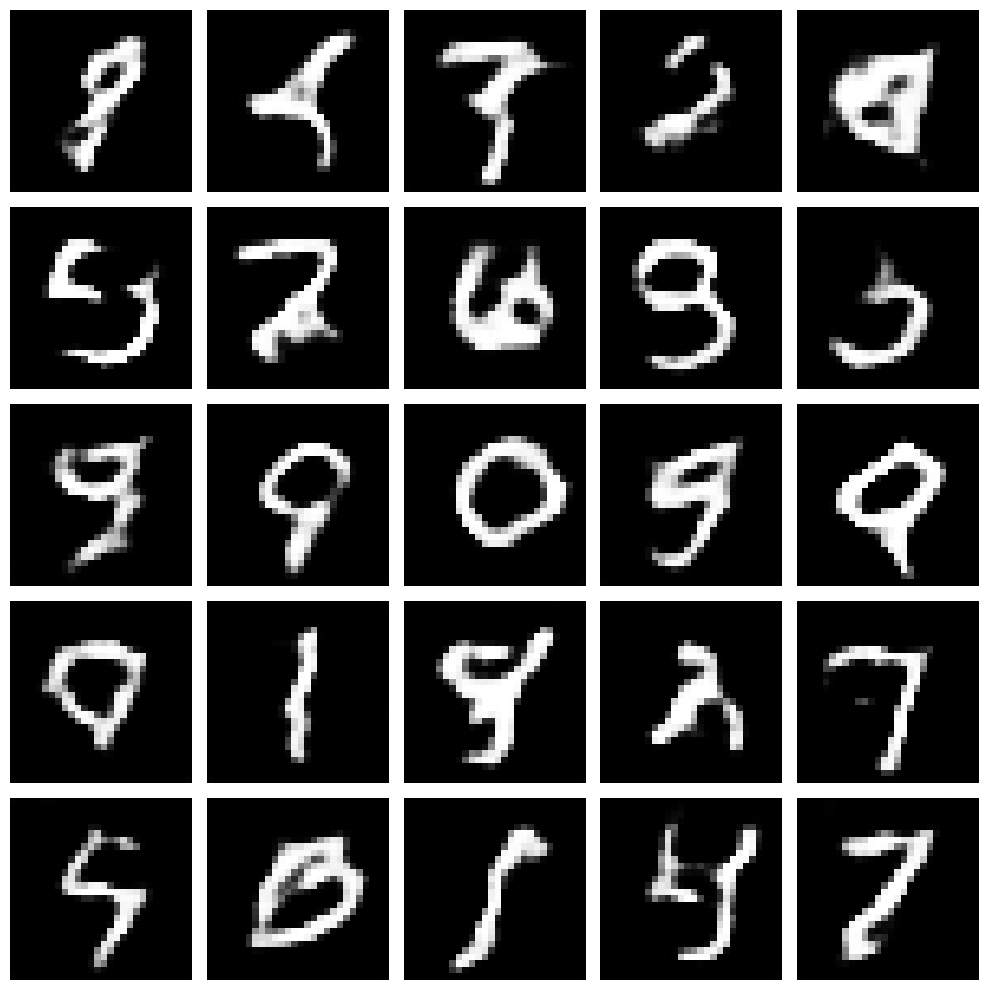

In [2]:
# 8. Quick Preview
LATENT_DIM = 100
N_SHOW     = 25           # Number of images to display
COLS       = 5            # grid columns

def sample_and_show(gen_model, n=N_SHOW, cols=COLS):
    noise = tf.random.normal([n, 1, 1, LATENT_DIM])
    imgs  = gen_model(noise, training=False)
    imgs  = (imgs + 1) / 2.0        # → [0,1] float32

    rows = (n + cols - 1) // cols
    plt.figure(figsize=(cols * 2, rows * 2))
    for i in range(n):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(imgs[i, :, :, 0], cmap="gray")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# 1) If you just finished training, `generator` is already in memory:
sample_and_show(generator)

# 2) If you’re in a fresh session, first reload the saved model:
# generator = tf.keras.models.load_model("dcgan_generator.h5", compile=False)
# sample_and_show(generator)


In [3]:
# Parameters you might tweak
NUM_IMAGES = 5000 #No. of images to generate
LATENT_DIM = 100  #must match training
FAKE_DIR   = "gen_samples_eval_dcgan"

# --------------------------------------
import tensorflow as tf, os, imageio
import numpy as np
from tqdm import tqdm

os.makedirs(FAKE_DIR, exist_ok=True)

# 1. Reload the trained generator (saved by the previous script)
generator = tf.keras.models.load_model("dcgan_generator.h5", compile=False)

# 2. Generate and save NUM_IMAGES PNGs
for i in tqdm(range(NUM_IMAGES), desc="Generating digits"):
    noise = tf.random.normal([1, 1, 1, LATENT_DIM])
    img   = generator(noise, training=False)       # shape (1,28,28,1), range [-1,1]
    img   = (img + 1) / 2.0                        # → [0,1] float32
    png   = tf.image.convert_image_dtype(img[0], tf.uint8)
    imageio.imwrite(f"{FAKE_DIR}/digit_{i:05d}.png", png.numpy().squeeze())

print(f"{NUM_IMAGES} images saved to {FAKE_DIR}/")


Generating digits: 100%|██████████| 5000/5000 [01:21<00:00, 61.63it/s]

5000 images saved to gen_samples_eval_dcgan/


In [4]:
REAL_DIR = "real_images_eval_dcgan"
os.makedirs(REAL_DIR, exist_ok=True)

# Make sure `train_images` (scaled to [-1,1]) is still in memory; if not, reload MNIST:
try:
    train_images
except NameError:
    (train_images, _), _ = tf.keras.datasets.mnist.load_data()
    train_images = train_images.reshape(-1, 28, 28, 1).astype("float32")
    train_images = (train_images - 127.5) / 127.5

# Save the first `NUM_IMAGES` samples
for i, img in enumerate(train_images[:NUM_IMAGES]):
    png = ((img + 1) / 2.0 * 255).astype(np.uint8).squeeze()
    imageio.imwrite(f"{REAL_DIR}/digit_{i:05d}.png", png)

print(f"{NUM_IMAGES} real images saved to {REAL_DIR}/")


5000 real images saved to real_images_eval_dcgan/


In [5]:
!pip install -q clean-fid
from cleanfid import fid

fid_score = fid.compute_fid(
    "/content/real_images_eval_dcgan",
    "/content/gen_samples_eval_dcgan"
)
print(f"FID = {fid_score:.2f}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 119.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 97.0 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


compute FID between two folders
Found 5000 images in the folder /content/real_images_eval_dcgan


FID real_images_eval_dcgan : 100%|██████████| 157/157 [00:32<00:00,  4.76it/s]


Found 5000 images in the folder /content/gen_samples_eval_dcgan


FID gen_samples_eval_dcgan : 100%|██████████| 157/157 [00:30<00:00,  5.15it/s]


FID = 40.18
